In [2]:
import os
# NOTE: material: https://drive.google.com/drive/u/0/folders/14J6oWZzULqtXfIv99064Cs0iHVdeat22

In [3]:
# NOTE: access to directory
dir_project = os.path.abspath(".")
print(f"{dir_project=}")
os.chdir(dir_project)
print(f"{os.getcwd()}")

dir_project='/root/Documents/Projects/augmented_safeguard/NeRF'
/root/Documents/Projects/augmented_safeguard/NeRF


In [4]:
def config_parser():
    import argparse
    parser = argparse.ArgumentParser()

    parser.add_argument("--expname", type=str, help="experiment name")
    parser.add_argument("--basedir", type=str, default="./logs/", help="where to store checkpoints and logs")
    parser.add_argument("--datadir", type=str, default="./data/llff/fern", help="input data directory")

    # NOTE: tranining options
    # ------------------------------------------
    parser.add_argument("--netdepth", type=int, default=8, help="layers in network")
    parser.add_argument("--netwidth", type=int, default=256, help="channels per layer")
    parser.add_argument("--netdepth_fine", type=int, default=8, help="layers in fine network")
    parser.add_argument("--netwidth_fine", type=int, default=256, help="channels per layer in fine network")
    parser.add_argument("--N_rand", type=int, default=32*32*4, help="batch size (number of random rays per gradient step)")
    parser.add_argument("--lrate", type=float, default=5e-4, help="learning rate")
    parser.add_argument("--lrate_decay", type=int, default=250, help="exponential learning rate decay (in 1000 steps)")
    
    ## NOTE: training options - batch size
    parser.add_argument("--chunk", type=int, default=1024*32, help="number of rays processed in parallel, decrease it if running out of memory")
    parser.add_argument("--netchunk", type=int, default=1024*64, help="number of points sent through network in parallel, decrease it if running out of memory")
    parser.add_argument("--no_batching", action="store_true", help="only take random rays from 1 image at a time")
    parser.add_argument("--no_reload", action="store_true", help="do not reload weights from saved checkpoint")
    parser.add_argument("--ft_path", type=str, default=None, help="specific weights npy file to reload for coarse network")

    ## NOTE: training options - precrop?
    parser.add_argument("--precrop_iters", type=int, default=0, help="number of steps to train on central crops")
    parser.add_argument("--precrop_frac", type=float, default=0.5, help="fraction of image taken for central crops")
    # ------------------------------------------


    # NOTE: rendering options
    # ------------------------------------------
    parser.add_argument("--N_samples", type=int, default=64, help="number of coarse samples per ray")
    parser.add_argument("--N_importance", type=int, default=0, help="number of additional fine samples per ray")
    parser.add_argument("--perturb", type=float, default=1., help="set to 0. for no jitter, 1. for jitter")
    parser.add_argument("--use_viewdirs", action="store_true", help="use full 5D input instead of 3D")
    parser.add_argument("--i_embed", type=int, default=0, help="set 0 for default positional encoding, -1 for none")
    parser.add_argument("--multires", type=int, default=10, help="log2 of max freq for positional encoding (3D location)")
    parser.add_argument("--multires_views", type=int, default=4, help="log2 of max freq for positional encoding (2D direction)")
    parser.add_argument("--raw_noise_std", type=float, default=0., help="std dev of noise added to regularize sigma_a output. 1e0 recommended")

    ## NOTE: rendering options - visualization related?
    parser.add_argument("--render_only", action="store_true", help="do not optimize, reload weights and render out render_poses path")
    parser.add_argument("--render_test", action="store_true", help="render the test set instead of render_poses path")
    parser.add_argument("--render_factor", type=int, default=0, help="downsampling factor to speed up rendering, set 4 or 8 for fast preview")
    # ------------------------------------------

    # NOTE: dataset options
    # ------------------------------------------
    parser.add_argument("--dataset_type", type=str, default="llff", help="options: llff / blender / deepvoxels")
    parser.add_argument("--testskip", type=int, default=8, help="will load 1/N images from test/val sets, useful for large datasets like deepvoxels")

    ## NOTE: dataset options - deepvoxels flags
    parser.add_argument("--shape", type=str, default="greek", help="options: armchair / cube / greek / vase")

    ## NOTE: dataset options - blender flags
    parser.add_argument("--white_bkgd", action="store_true", help="set to render synthetic data on a white background (always true for deepvoxels)")
    parser.add_argument("--half_res", action="store_true", help="load blender synthetic data at 400*400, instead of 800*800")

    ## NOTE: dataset options - LLFF flags
    parser.add_argument("--factor", type=int, default=8, help="downsample factor for LLFF images")
    parser.add_argument("--no_ndc", action="store_true", help="do not use normalized device coordinates (set for non-forward facing scenes)")
    parser.add_argument("--lindisp", action="store_true", help="sampling linearly in disparity rather than depth")
    parser.add_argument("--spherify", action="store_true", help="set for spherical 360deg scenes")
    parser.add_argument("--llffhold", type=int, default=8, help="will take every 1/N images as LLFF test set, paper uses 8")
    # ------------------------------------------
    
    # NOTE: Logging / Saving options
    # ------------------------------------------
    parser.add_argument("--i_print", type=int, default=100, help="frequency of console printout and metric logging")
    parser.add_argument("--i_img", type=int, default=500, help="frequency of tensorboard image logging")
    parser.add_argument("--i_weights", type=int, default=10000, help="frequency of weight checkpoint saving")
    parser.add_argument("--i_testset", type=int, default=50000, help="frequency of testset saving")
    parser.add_argument("--i_video", type=int, default=50000, help="frequency of render_poses video saving")
    # ------------------------------------------

    return parser


In [5]:
# NOTE: parse arguments & load config

parser = config_parser()
args = parser.parse_args(args=[])
args.config = "configs/lego.txt"

# NOTE: load config
with open(args.config, "r") as fp:
    lines = fp.readlines()
    lines = [
        line.strip() 
        for line 
        in lines
    ]
    lines = [
        line.split(" = ") 
        for line 
        in lines 
        if len(line) > 0
    ]

configs = {}
for line in lines:
    configs[line[0]] = line[1]

print(configs)

{'expname': 'blender_paper_lego', 'basedir': './logs', 'datadir': './data/nerf_synthetic/lego', 'dataset_type': 'blender', 'no_batching': 'True', 'use_viewdirs': 'True', 'white_bkgd': 'True', 'lrate_decay': '500', 'N_samples': '64', 'N_importance': '128', 'N_rand': '1024', 'precrop_iters': '500', 'precrop_frac': '0.5', 'half_res': 'True'}


In [6]:
# NOTE: append config

args.expname = configs['expname']
args.basedir = configs['basedir']
args.datadir = configs['datadir']
args.dataset_type = configs['dataset_type']
args.no_batching = configs['no_batching']
args.use_viewdirs = configs['use_viewdirs']
args.white_bkgd = configs['white_bkgd']
args.lrate_decay = int(configs['lrate_decay'])
args.N_samples = int(configs['N_samples'])
args.N_importance = int(configs['N_importance'])
args.N_rand = int(configs['N_rand'])
args.precrop_iters = int(configs['precrop_iters'])
args.precrop_frac = float(configs['precrop_frac'])
args.half_res = configs['half_res']

args.no_reload = True
print(args)

Namespace(N_importance=128, N_rand=1024, N_samples=64, basedir='./logs', chunk=32768, config='configs/lego.txt', datadir='./data/nerf_synthetic/lego', dataset_type='blender', expname='blender_paper_lego', factor=8, ft_path=None, half_res='True', i_embed=0, i_img=500, i_print=100, i_testset=50000, i_video=50000, i_weights=10000, lindisp=False, llffhold=8, lrate=0.0005, lrate_decay=500, multires=10, multires_views=4, netchunk=65536, netdepth=8, netdepth_fine=8, netwidth=256, netwidth_fine=256, no_batching='True', no_ndc=False, no_reload=True, perturb=1.0, precrop_frac=0.5, precrop_iters=500, raw_noise_std=0.0, render_factor=0, render_only=False, render_test=False, shape='greek', spherify=False, testskip=8, use_viewdirs='True', white_bkgd='True')


In [7]:
# NOTE: device

import json
import random
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange


device = torch.device("cuda")
DEBUG = False
print(device)

cuda


## Preprocessing: Blender dataset

{'camera_angle_x': 0.6911112070083618, 'frames': [{'file_path': './test/r_0', 'rotation': 0.031415926535897934, 'transform_matrix': [[-0.9999999403953552, 0.0, 0.0, 0.0], [0.0, -0.7341099977493286, 0.6790305972099304, 2.737260103225708], [0.0, 0.6790306568145752, 0.7341098785400391, 2.95929169654846
{'file_path': './test/r_0', 'rotation': 0.031415926535897934, 'transform_matrix': [[-0.9999999403953552, 0.0, 0.0, 0.0], [0.0, -0.7341099977493286, 0.6790305972099304, 2.737260103225708], [0.0, 0.6790306568145752, 0.7341098785400391, 2.959291696548462], [0.0, 0.0, 0.0, 1.0]]}
./data/nerf_synthetic/lego/./test/r_0.png
(800, 800, 4)


/tmp/ipykernel_3407/4211448802.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(_fname) # [800, 800, 4 = RGB+mask(synthetic; from Blender)]
/tmp/ipykernel_3407/4211448802.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(_fname)
/tmp/ipykernel_3407/4211448802.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(_f

(10, 800, 800, 4)


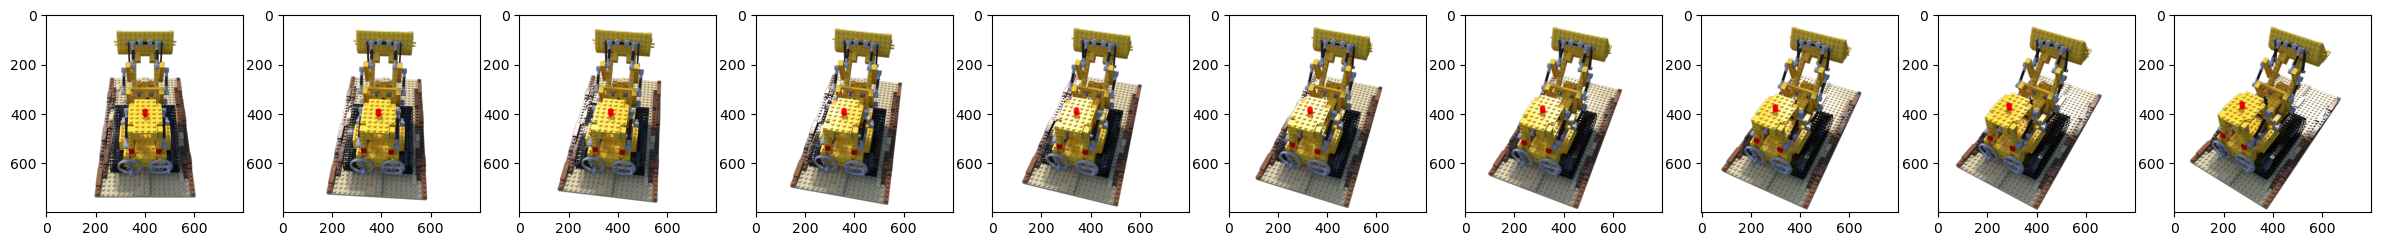

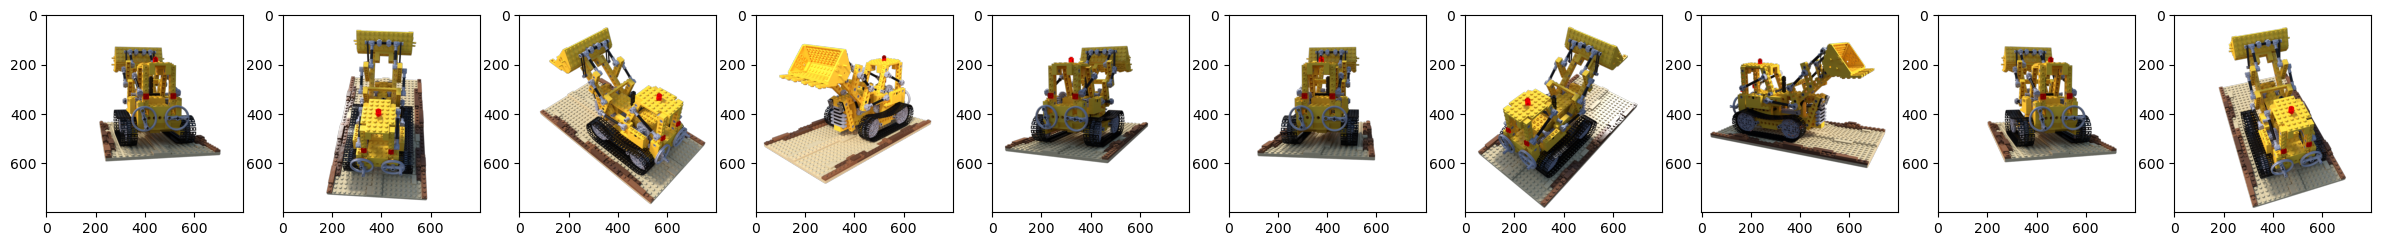

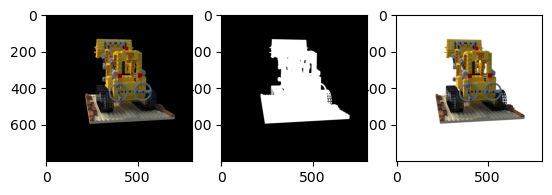

In [17]:
_datadir = "./data/nerf_synthetic/lego"

with open(os.path.join(_datadir, "transforms_test.json"), "r") as fp:
    meta = json.load(fp)

print(str(meta)[:300])

_frames = meta['frames']
_frame = _frames[0]
print(_frame)

_fname = os.path.join(_datadir, _frame['file_path'] + ".png")
print(_fname)

import imageio
img = imageio.imread(_fname) # [800, 800, 4 = RGB+mask(synthetic; from Blender)]
print(img.shape)

# NOTE: sequential visualization
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 10, figsize=(30, 300))
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame["file_path"] + ".png")

    img = imageio.imread(_fname)

    axis[i].imshow(img)

# NOTE: random shuffled visualization
import random
random.shuffle(_frames)
fig, axis = plt.subplots(1, 10, figsize=(30, 300))
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame["file_path"] + ".png")

    img = imageio.imread(_fname)

    axis[i].imshow(img)

# NOTE: decomposed channel visualization
imgs = []
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame["file_path"] + ".png")

    img = imageio.imread(_fname)
    imgs.append(img)

imgs = (np.array(imgs) / 255.0).astype(np.float32) # [0., 1.]
print(imgs.shape)

imgs_orig = imgs[..., :3] # RGB
imgs_mask = imgs[..., -1] # mask

fig, axis = plt.subplots(1, 3)
axis[0].imshow(imgs_orig[0])
axis[1].imshow(imgs_mask[0], cmap="gray")

# NOTE: how plt operates with mask
imgs = imgs[..., :3] * imgs[..., -1:] + (1-imgs[..., -1:]) # `-1:`: broadcast 
axis[2].imshow(imgs[0])